In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.decomposition import FactorAnalysis as FA
from scipy.stats import special_ortho_group as sog

from neuropacks import PVC11

from noise_correlations.analysis import generate_dimlets_and_stim_pairs
from noise_correlations.discriminability import lfi

In [2]:
def plot_ellipse(mu, cov, ax, c='C0', alpha=.25, n_std=2, ec=None):
    e, v = np.linalg.eigh(cov)
    e = np.sqrt(e)
    ell = Ellipse(mu, 2*e[1]*n_std, 2*e[0]*n_std,
                  180. * np.arctan2(v[1, -1], v[0, -1]) / np.pi,
                  facecolor=c, alpha=.25, edgecolor=ec)
    ax.plot(mu[0], mu[1], 'o', c=c)
    ax.add_artist(ell)

In [3]:
pcv = PVC11('/storage/pvc11/spikes_gratings/data_monkey1_gratings.mat')

In [100]:
X = pcv.get_design_matrix(form='angle')
Y = pcv.get_response_matrix()
X.shape, Y.shape

((2400,), (2400, 106))

0.5305009306908158


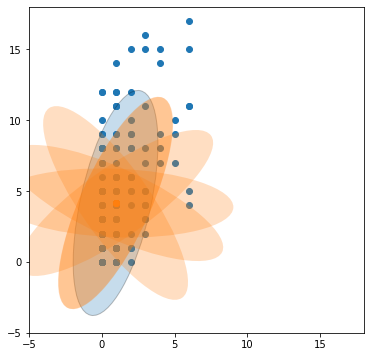

In [101]:
ni = 0
nj = 1
s = np.unique(X)[0]
idxs = np.equal(X, s)
Yi = Y[idxs][:, [ni, nj]]
print(np.corrcoef(Yi.T)[0, 1])

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(*Yi.T)
maxv = Yi.max()
ax.set_xlim(-5, maxv+1)
ax.set_ylim(-5, maxv+1)
mean = Yi.mean(axis=0)
cov = np.cov(Yi.T)
plot_ellipse(mean, cov, ax, ec='k')
for ii in range(6):
    R = sog(2).rvs()
    plot_ellipse(mean, R@cov@R.T, ax, c='C1', alpha=.05)

In [102]:
model = FA(n_components=1, tol=1e-8, svd_method='lapack')
model.fit(Yi)
print(model.loglike_[-1])
print(model.noise_variance_)
print(np.linalg.norm(cov - model.get_covariance()))

model = FA(n_components=1, tol=1e-8, svd_method='lapack', noise_variance_init=np.diag(cov))
model.fit(Yi)
print(model.loglike_[-1])
print(model.noise_variance_)
print(np.linalg.norm(cov - model.get_covariance()))

-884.1934617731154
[1.47302669 1.02082234]
0.08230865813517892
-884.1934617741462
[0.98947359 7.35284518]
0.08229523366678264


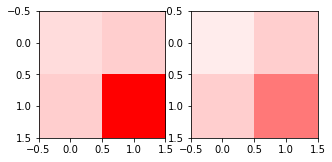

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(5, 10))
maxv = max(abs(np.cov(Yi.T)).max(), abs(model.components_.T @ model.components_).max())
axes[0].imshow(np.cov(Yi.T), cmap='bwr', vmin=-maxv, vmax=maxv)
axes[1].imshow(model.components_.T @ model.components_, cmap='bwr', vmin=-maxv, vmax=maxv)

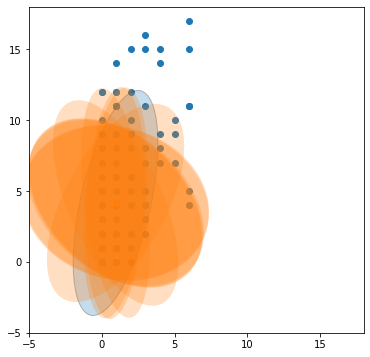

In [104]:
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(*Yi.T)
maxv = Yi.max()
ax.set_xlim(-5, maxv+1)
ax.set_ylim(-5, maxv+1)
mean = Yi.mean(axis=0)
cov = np.cov(Yi.T)
plot_ellipse(mean, cov, ax, ec='k')
for ii in range(10):
    R = sog(2).rvs()
    covp = np.diag(model.noise_variance_) + R @ model.components_.T @ model.components_ @R.T
    plot_ellipse(mean, covp, ax, c='C1', alpha=.05)

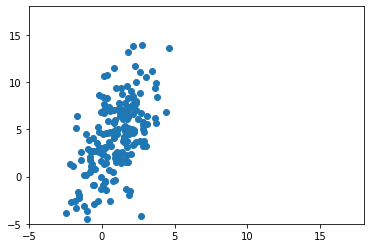

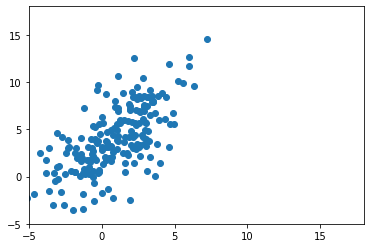

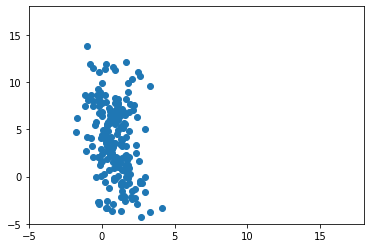

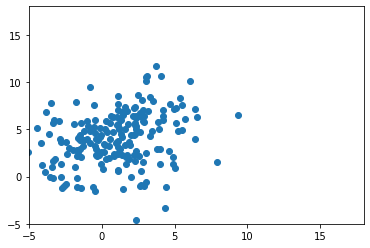

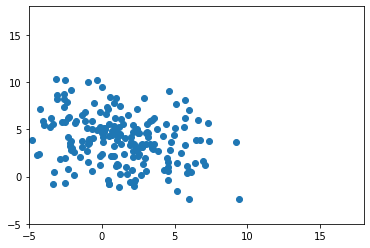

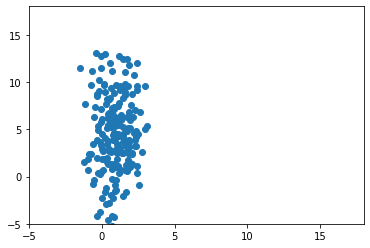

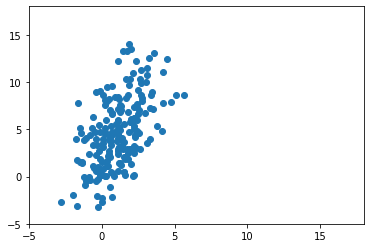

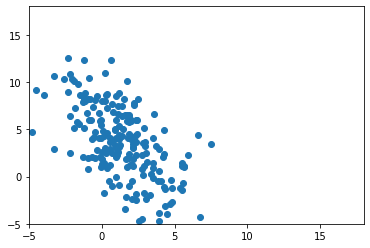

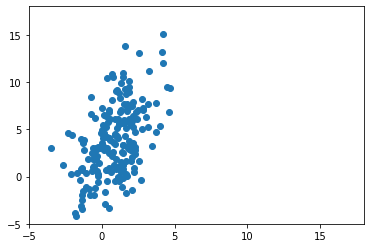

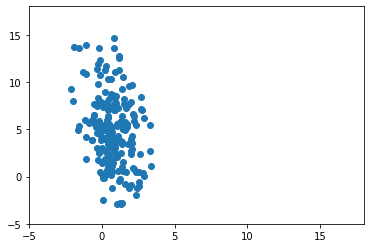

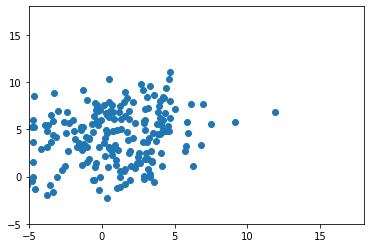

In [105]:
plt.figure()
mean = Yi.mean(axis=0)
cov = np.cov(Yi.T)
plt.scatter(*np.random.multivariate_normal(mean, cov, size=Yi.shape[0]).T)
plt.xlim(-5, maxv+1)
plt.ylim(-5, maxv+1)
for ii in range(10):
    R = sog(2).rvs()
    covp = np.diag(model.noise_variance_) + R @ model.components_.T @ model.components_ @R.T
    plt.figure()
    plt.scatter(*np.random.multivariate_normal(mean, covp, size=Yi.shape[0]).T)
    plt.xlim(-5, maxv+1)
    plt.ylim(-5, maxv+1)

In [106]:
ns = np.random.choice(np.arange(Y.shape[1]), replace=False, size=2)
s = np.unique(X)[0]
idxs = np.equal(X, s)
Yi = Y[idxs][:, ns]
cov = np.cov(Yi.T)

-887.5426026962199
[2.98625331 4.17106088]
0.040136900109245206
-887.5426026934122
[3.78037108 1.71199827]
0.040151388178701966

-887.5426026934249
[3.72074108 5.19695951]
0.8619936928415571
-887.5426026932163
[1. 1.]
0.04014957390703185

-987.5426026934249
[3.72074108 5.19695951]
0.8619936928415571
-987.5426026932163
[1. 1.]
0.04014957390703185

-1087.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1087.5426026932162
[1. 1.]
0.04014957390703185

-1187.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1187.5426026932162
[1. 1.]
0.04014957390703185

-1287.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1287.5426026932162
[1. 1.]
0.04014957390703185

-1387.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1387.5426026932162
[1. 1.]
0.04014957390703185

-1487.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1487.5426026932162
[1. 1.]
0.04014957390703185

-1587.542602693425
[3.72074108 5.19695951]
0.8619936928415571
-1587.5426026932162
[1. 1.]
0.0401

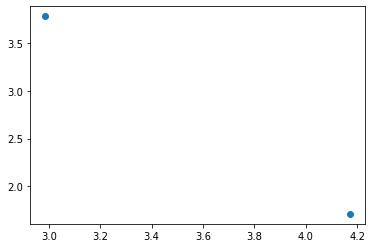

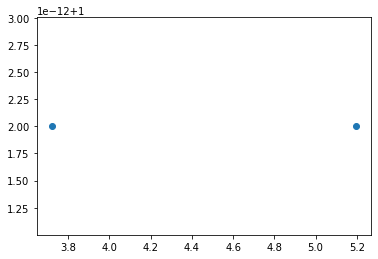

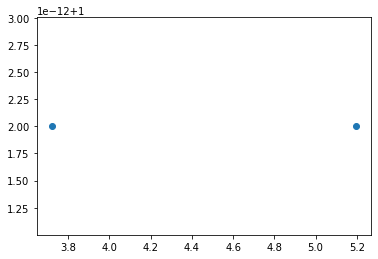

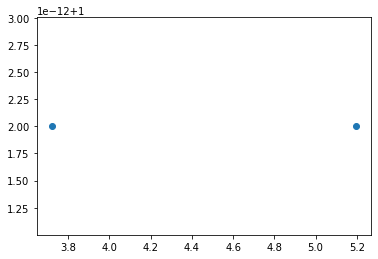

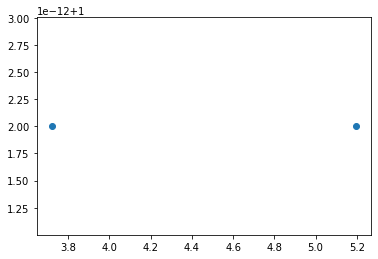

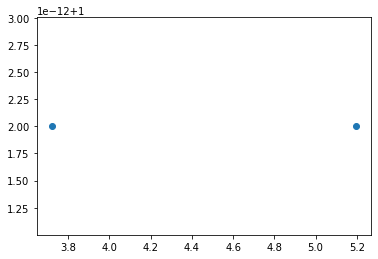

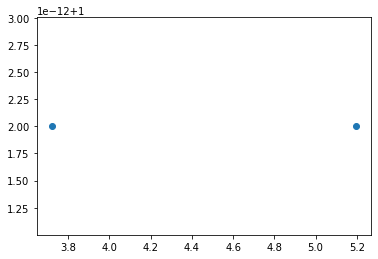

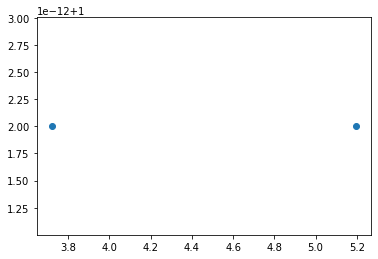

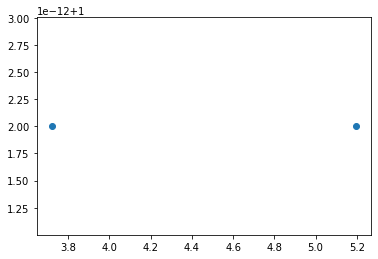

In [107]:
for ii in range(1, 10):
    model = FA(n_components=ii, tol=1e-8, svd_method='lapack', noise_variance_init=np.diag(cov))
    model.fit(Yi)
    print(model.loglike_[-1])
    nv = model.noise_variance_
    print(nv)
    print(np.linalg.norm(cov - model.get_covariance()))
    model = FA(n_components=ii, tol=1e-8, svd_method='lapack')
    model.fit(Yi)
    print(model.loglike_[-1])
    print(model.noise_variance_)
    print(np.linalg.norm(cov - model.get_covariance()))
    plt.figure()
    plt.scatter(nv, model.noise_variance_)
    print()

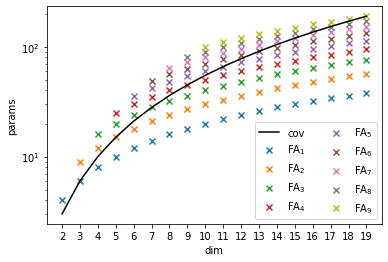

In [108]:
dims = np.arange(2, 20)
ks = np.arange(1, 10)
def n_params(n, k):
    ncov = (n**2 + n) // 2
    nfa = n + n*k
    return ncov, nfa

ncov, nfa = n_params(dims, 1)
plt.plot(dims, ncov, c='k', label='cov')
for ii, k in enumerate(ks):
    ds = dims[dims > k]
    ncov, nfa = n_params(ds, k)
    plt.scatter(ds, nfa, marker='x', c=f'C{ii}', label=r'FA$_{}$'.format(k))
plt.xticks(dims)
plt.legend(loc='best', ncol=2)
plt.xlabel('dim')
plt.ylabel('params')
plt.yscale('log')
plt.savefig('n_params.jpg', dpi=300)

# Dim-stims

In [161]:
class MVNCov:
    def __init__(self, X):
        self.mean = X.mean(axis=0, keepdims=True)
        self.cov = np.cov(X.T)
    def rot(self, R=None):
        if R is None:
            cov = self.cov
        else:
            cov = R @ self.cov @ R.T
        return self.mean, cov
class FACov:
    def __init__(self, X, k=1):
        self.mean = X.mean(axis=0, keepdims=True)
        model = FA(n_components=k, tol=1e-8, svd_method='lapack',
                   noise_variance_init=np.var(X, axis=0))
        model.fit(X)
        self.private = model.noise_variance_
        self.shared = model.components_.T @ model.components_
    def rot(self, R=None):
        if R is None:
            cov = np.diag(self.private) + self.shared
        else:
            cov = np.diag(self.private) + R @ self.shared @ R.T
        return self.mean, cov

In [110]:
def inner_calculate_nulls_measures_FA(X, stimuli, unit_idxs, stim_vals, rng,
                                      k, n_repeats, circular_stim=False):
    """Calculates LFI on a dimlet of a neural design matrix under
    both the shuffled and rotation null models for the covariance and FA models.

    Parameters
    ----------
    X : ndarray (samples, units)
        Neural data design matrix.
    stimuli : ndarray (samples,)
        The stimulus value for each trial.
    unit_idxs : ndarray (dim,)
        The indices for the units in the dimlet.
    stim_vals : ndarray
        The values of a randomly chosen pair of stimuli.
    rng : RandomState
        Random state instance.
    n_repeats : int
        The number of repetitions to consider when evaluating null models.
    circular_stim : bool
        Indicates whether the stimulus is circular.

    Returns
    -------
    v_r_lfi : ndarray (reps,)
        The values of the LFI/sDKL on the rotated dimlets.
    v_lfi : float
        The values of the LFI/sDKL on the original dimlet.
    """
    n_samples = X.shape[0]
    n_units = unit_idxs.size
    # Segment design matrix according to stimuli and units
    stim0_idx = np.argwhere(stimuli == stim_vals[0]).ravel()
    stim1_idx = np.argwhere(stimuli == stim_vals[1]).ravel()
    X0 = X[stim0_idx][:, unit_idxs]
    X1 = X[stim1_idx][:, unit_idxs]
    # Sub-design matrix statistics
    mvn0 = MVN(X0)
    mvn1 = MVN(X1)
    fac0 = FAC(X0, k=k)
    fac1 = FAC(X1, k=k)
    # Calculate stimulus difference
    if circular_stim:
        dtheta = np.ediff1d(np.unique(stimuli))[0]
    else:
        dtheta = np.diff(stim_vals).item()

    # Calculate values of LFI and sDKL for original datasets
    v_lfi = np.zeros(2)
    mu0, cov0 = mvn0.rot()
    mu1, cov1 = mvn1.rot()
    v_lfi[0] = lfi(mu0, cov0, mu1, cov1, dtheta=dtheta)
    mu0, cov0 = fac0.rot()
    mu1, cov1 = fac1.rot()
    v_lfi[1] = lfi(mu0, cov0, mu1, cov1, dtheta=dtheta)
    print(v_lfi)
    # Values for measures on rotated data
    v_r_lfi = np.zeros((2, n_repeats))

    for jj in range(n_repeats):
        # Rotation null model
        R = sog.rvs(n_units, random_state=rng)
        mu0, cov0r = mvn0.rot(R)
        mu1, cov1r = mvn1.rot(R)
        v_r_lfi[0, jj] = lfi(mu0, cov0r, mu1, cov1r, dtheta=dtheta)
        mu0, cov0r = fac0.rot(R)
        mu1, cov1r = fac1.rot(R)
        v_r_lfi[1, jj] = lfi(mu0, cov0r, mu1, cov1r, dtheta=dtheta)
    return v_r_lfi, v_lfi

In [133]:
rng = np.random.RandomState(0)
k = 1
dim = 10
samples = 100
n_repeats = 100
units, stims = generate_dimlets_and_stim_pairs(Y.shape[1], X, dim, samples, rng,
                                               circular_stim=True)

lfis = np.zeros((units.shape[0], 2))
r_lfis = np.zeros((units.shape[0], 2, n_repeats))

for ii in range(units.shape[0]):
    if (ii % 10) == 0:
        print(float(ii) / units.shape[0])
    v_r_lfi, v_lfi = inner_calculate_nulls_measures_FA(Y, X, units[ii], stims[ii], rng,
                                                       k=k, n_repeats=n_repeats,
                                                       circular_stim=True)
    lfis[ii] = v_lfi
    r_lfis[ii] = v_r_lfi

0.0
[0.01794141 0.01663475]
[0.00383472 0.00351282]
[0.00753571 0.00790226]
[0.00783391 0.00747344]
[0.00664359 0.00641555]
[0.00781514 0.00755936]
[0.00900777 0.00942562]
[0.00539425 0.00565749]
[0.00451461 0.00426962]
[0.00915847 0.00819095]
0.008333333333333333
[0.00826051 0.00828867]
[0.00639257 0.00607694]
[0.01023785 0.01005521]
[0.02099891 0.02321332]
[0.01283884 0.01275215]
[0.01126706 0.01129528]
[0.00600584 0.00607001]
[0.0110452  0.01356875]
[0.01895146 0.01531716]
[0.02571245 0.02844906]
0.016666666666666666
[0.01097364 0.01127208]
[0.01153993 0.01046476]
[0.00560267 0.00567682]
[0.00898734 0.01146823]
[0.01586814 0.0167736 ]
[0.00425099 0.00392982]
[0.00541989 0.00522909]
[0.00931391 0.00807362]
[0.00885077 0.00699396]
[0.00687986 0.00763069]
0.025
[0.00982212 0.01049343]
[0.00249514 0.00212377]
[0.00574317 0.00507539]
[0.00707234 0.00557328]
[0.00626063 0.00552012]
[0.00819692 0.00744267]
[0.00702266 0.00784045]
[0.01123322 0.01259957]
[0.00979092 0.009947  ]
[0.00545657 

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ii in range(3):
    v_r_lfi, v_lfi = r_lfis[ii], lfis[ii]
    bins = np.linspace(v_r_lfi.min(), v_r_lfi.max(), 100)
    axes[0, ii].hist(v_r_lfi[0], bins=bins, log=True)
    axes[0, ii].axvline(v_lfi[0], 0, 1, c='k')
    axes[0, ii].set_xlabel('Cov LFI')
    axes[0, ii].set_ylabel('Null counts')


    axes[1, ii].hist(v_r_lfi[1], bins=bins, log=True)
    axes[1, ii].axvline(v_lfi[1], 0, 1, c='k')
    axes[1, ii].set_xlabel(r'FA$_{}$ LFI'.format(k))
    axes[1, ii].set_ylabel('Null counts')

    bins = np.linspace(v_r_lfi[1].min(), v_r_lfi[1].max(), 100)
    axes[2, ii].hist(v_r_lfi[1], bins=bins, log=True)
    axes[2, ii].axvline(v_lfi[1], 0, 1, c='k')
    axes[2, ii].set_xlabel(r'FA$_{}$ LFI (zoom)'.format(k))
    axes[2, ii].set_ylabel('Null counts')
axes[0, 1].set_title(f'Dim: {dim}, k: {k}')
fig.tight_layout()
plt.savefig('cov_fa.jpg')

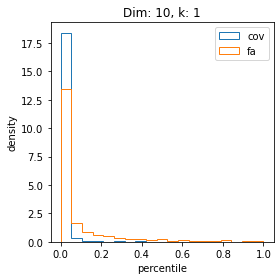

In [160]:
fig, ax = plt.subplots(1, figsize=(4, 4))
ps = np.mean(r_lfis <= lfis[..., np.newaxis], axis=-1)
bins = np.linspace(0, 1, 20)
ax.hist(ps[:, 0], bins=bins, histtype='step', label='cov', density=True)
ax.hist(ps[:, 1], bins=bins, histtype='step', label='fa', density=True)
ax.legend(loc='best')
ax.set_title(f'Dim: {dim}, k: {k}')
ax.set_xlabel('percentile')
ax.set_ylabel('density')
fig.tight_layout()
plt.savefig('cov_fa_ps.jpg')

In [144]:
ps.shape

(1200, 2)

In [137]:
lfis.shape

(1200, 2)

array([[1.  , 0.99],
       [1.  , 1.  ],
       [1.  , 0.92],
       ...,
       [1.  , 1.  ],
       [1.  , 0.91],
       [1.  , 0.99]])